# Ernesto Antonio Reyes Ramírez

# Visión Computacional

# Tarea 7: Análisis de Fourier

In [1]:
#Librerias utiles
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib.pyplot import figure
from scipy import signal
from PIL import Image

### 1.Amplitud vs fase

In [2]:
# cargar imágenes
img1 = Image.open('img1.png').convert('L')
img2 = Image.open('img2.png').convert('L')

# convertir imágenes a matrices numpy
img1_arr = np.array(img1)
img2_arr = np.array(img2)

In [3]:
#Calculamos las transformadas de fourier
fft1 = np.fft.fft2(img1_arr)
fft2 = np.fft.fft2(img2_arr)

In [4]:
#Extraemos la amplitud y fase
amplitude1 = np.abs(fft1)
phase1 = np.angle(fft1)

amplitude2 = np.abs(fft2)
phase2 = np.angle(fft2)

In [5]:
# combinar componente de amplitud y fase
res1_fft = amplitude1 * np.exp(1j * phase2)
res2_fft = amplitude2 * np.exp(1j * phase1)

# invertir la transformada de Fourier y convertir de vuelta a imagen
res1_arr = np.real(np.fft.ifft2(res1_fft)).astype(np.uint8)
res1 = Image.fromarray(res1_arr)

res2_arr = np.real(np.fft.ifft2(res2_fft)).astype(np.uint8)
res2 = Image.fromarray(res2_arr)

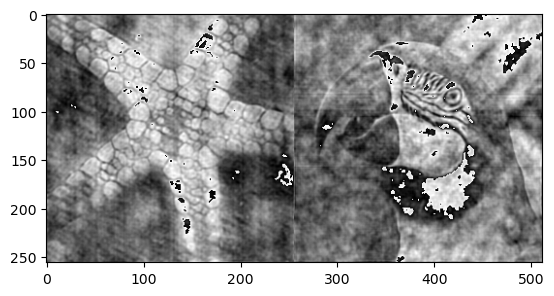

In [6]:
# Mostrar la imagen con matplotlib
plt.imshow(np.concatenate((res1_arr,res2_arr), axis = 1),"gray")
plt.show()

In [7]:
# guardar imágenes
res1.save('res1.png')
res2.save('res2.png')

Obtenemos nuestras imagenes donde comparten las especificaciones pedidas.

### 2. Remover la degradación periódica

In [8]:
from scipy.spatial import distance

In [254]:
def idealFilterLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance.euclidean((y,x),center) < D0:
                base[y,x] = 1
    return base

In [255]:
# Cargar la imagen
img = np.array(Image.open('img3.png'))

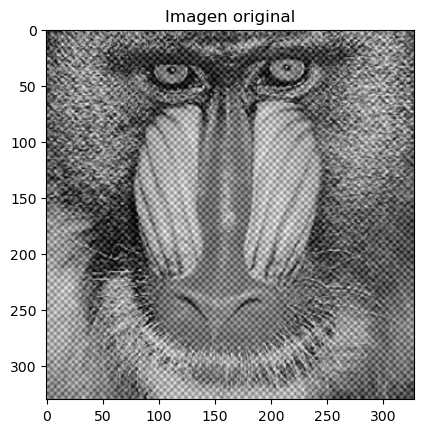

In [256]:
plt.imshow(img,"gray")
plt.title("Imagen original")
plt.show()

In [257]:
# Aplicar la transformada de Fourier 2D
f_img = np.fft.fft2(img)

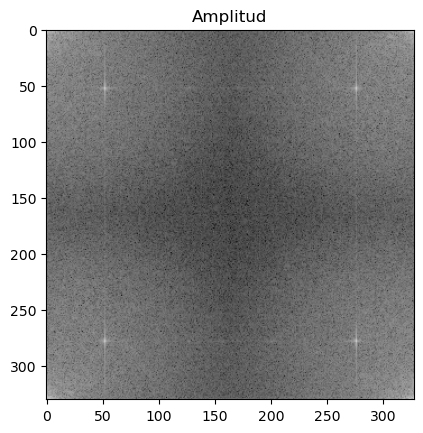

In [258]:
plt.imshow(np.log(1+np.abs(f_img)),"gray")
plt.title("Amplitud")
plt.show()

In [259]:
center = np.fft.fftshift(f_img)

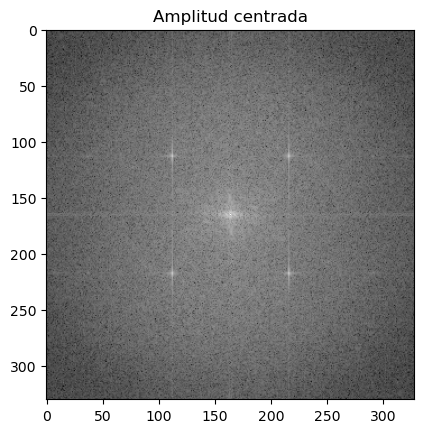

In [260]:
plt.imshow(np.log(1+np.abs(center)),"gray")
plt.title("Amplitud centrada")
plt.show()

In [261]:
LowPassCenter = center * idealFilterLP(50,img.shape)

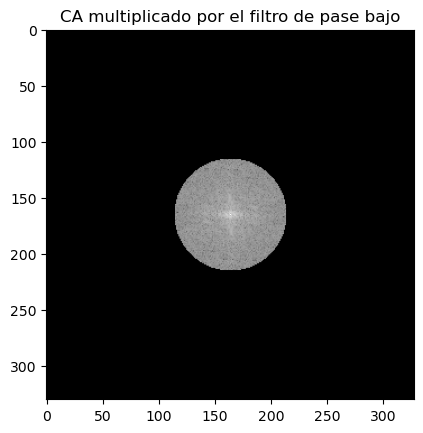

In [262]:
plt.imshow(np.log(1+np.abs(LowPassCenter)),"gray")
plt.title("CA multiplicado por el filtro de pase bajo")
plt.show()

In [265]:
LowPass = np.fft.ifftshift(LowPassCenter)

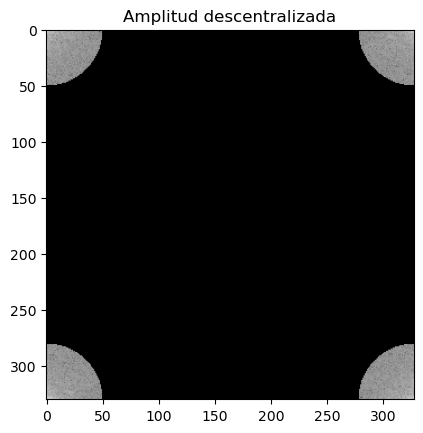

In [266]:
plt.imshow(np.log(1+np.abs(LowPass)),"gray")
plt.title("Amplitud descentralizada")
plt.show()

In [267]:
inverse_LowPass = np.fft.ifft2(LowPass)

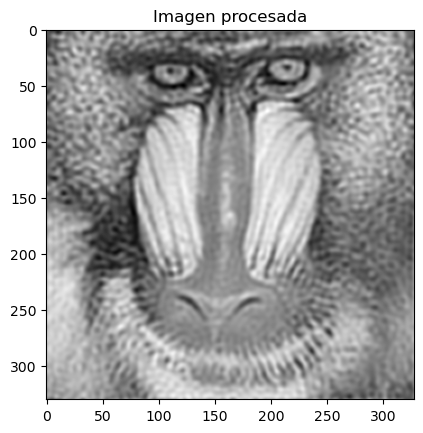

In [268]:
plt.imshow(np.abs(inverse_LowPass),"gray")
plt.title("Imagen procesada")
plt.show()

In [269]:
proc_img = inverse_LowPass.real.astype('uint8')

In [270]:
# Guardar la imagen procesada
Image.fromarray(proc_img).save('img3-proc.png')

Como podemos ver hemos obtenido una reducción en los patrones que se veían en nuestra imagen original.

### 3. Mejora en la imagen

#### 1. Determien una expresión del míninmo del funcional E.

Recordemos del problema 4 de la tarea 6 que,

$$
\nabla E(u) = u-u_0 - \gamma(u-w*u)
$$

Igualando a cero la ecuación anterior,
 
$$
\nabla E(u) = u-u_0 - \gamma(u-w*u) = 0
$$

Despejando,

$$
u-\gamma (u - w*u) = u_0
$$

y

$$
u - \gamma u + \gamma (w*u) = u_0
$$

Aplicando la transformada de Fourier a ambos lados,

$$
\hat{u} - \gamma \hat{u} + \gamma (\hat{w} \cdot \hat{u}) = \hat{u_0}
$$

Luego factorizando $\hat{u}$,

$$
\hat{u} (1 - \gamma + \gamma \hat{w}) = \hat{u_0}
$$

Despejando,

$$
\hat{u} = \frac{\hat{u_0}}{1 - \gamma + \gamma \hat{w}}
$$

Finalmente, aplicando la transformada de Fourier inversa,

$$
u = F^{-1}\left(\frac{\hat{u_0}}{1 - \gamma + \gamma \hat{w}}\right)
$$

donde $F^{-1}$ es la transformada inversa de Fourier. 

In [68]:
# Cargar la imagen
img4 = np.array(Image.open('img4.png'))

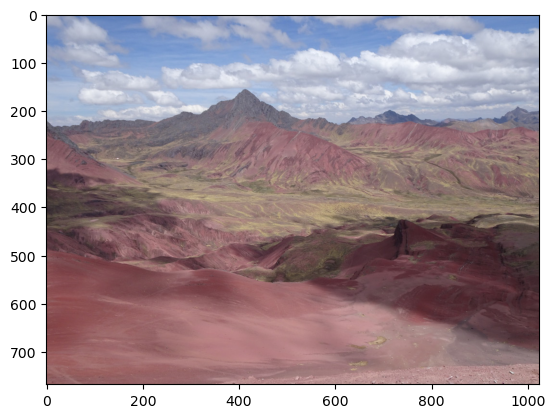

In [252]:
plt.imshow( img4)
plt.show()

In [251]:
#Pasamos la imagen al espacio oponente
r, g, b = np.split(img4, 3, axis=2)
o1 = (r - g) / np.sqrt(2)
o2 = (r + g - 2 * b) / np.sqrt(6)
o3 = (r + g + b) / np.sqrt(3)
opponent_img = np.concatenate((o1, o2, o3), axis=2)

# Normalizar el espacio de color oponente utilizando cv2.normalize()
normalized_img = cv2.normalize(opponent_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

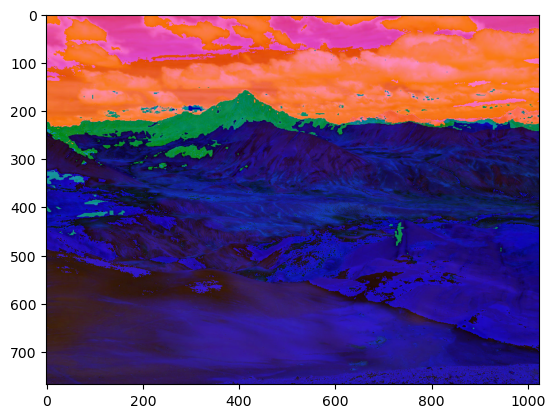

In [253]:
plt.imshow( normalized_img)
plt.show()

In [271]:
from scipy import signal

def gaussian_kernel(u,sigma):
    gaussian_kernel_1d_1 = np.expand_dims(signal.gaussian(u.shape[0],sigma),axis=1)
    gaussian_kernel_1d_2 = np.expand_dims(signal.gaussian(u.shape[1],sigma),axis=1)
    gaussian_kernel_2d = np.matmul(gaussian_kernel_1d_1,np.transpose(gaussian_kernel_1d_2))
    gaussian_kernel_2d = gaussian_kernel_2d/np.sum(gaussian_kernel_2d)
    return gaussian_kernel_2d

### 4. Clasifiación de formas

In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [70]:
#Cargamos las curvas
curvas = np.load('shapes.npy')

In [71]:
# Mostramos la primera curva
x = curvas[0,:,0]
y = curvas[0,:,1]

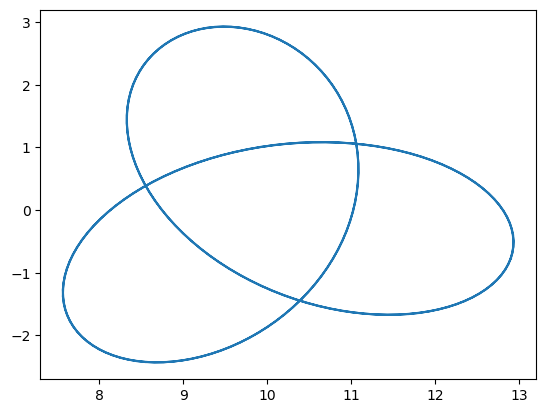

In [72]:
plt.plot(x,y)
plt.show()

In [232]:
def fourier_descriptors(curve, num_descriptores):
    
    fourier_transform = np.fft.fft(curve[:, 0] + 1j * curve[:, 1])
    
    # Obtiene los coeficientes de la representación de Fourier
    descriptors = fourier_transform[:num_descriptores]
    
    norm_descriptors = np.abs(descriptors)
    
    norm_segundo = norm_descriptors[1]
    
    # Normaliza los descriptores de Fourier a partir del tercero
    
    final_descriptors = norm_descriptors[2:]/norm_segundo
    
    return final_descriptors

In [235]:
# Vamos a calcular los descriptores de todas las curvas

num_descriptores = 10
X = np.zeros((curvas.shape[0],num_descriptores-2))

In [236]:
for i in range(curvas.shape[0]):
    X[i] = fourier_descriptors(curvas[i], num_descriptores)

In [240]:
kmeans = KMeans(n_clusters=5,init='k-means++').fit(X)

C:\Users\ernes\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ernes\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [241]:
#Los centroides
centroids = kmeans.cluster_centers_
print(centroids.shape)

(5, 8)


In [242]:
labels = kmeans.predict(X)

In [243]:
labels

array([2, 1, 4, 1, 2, 3, 2, 1, 4, 4, 0, 4, 3, 3, 3, 2, 1, 0, 0, 2, 0, 3,
       4, 0, 1])

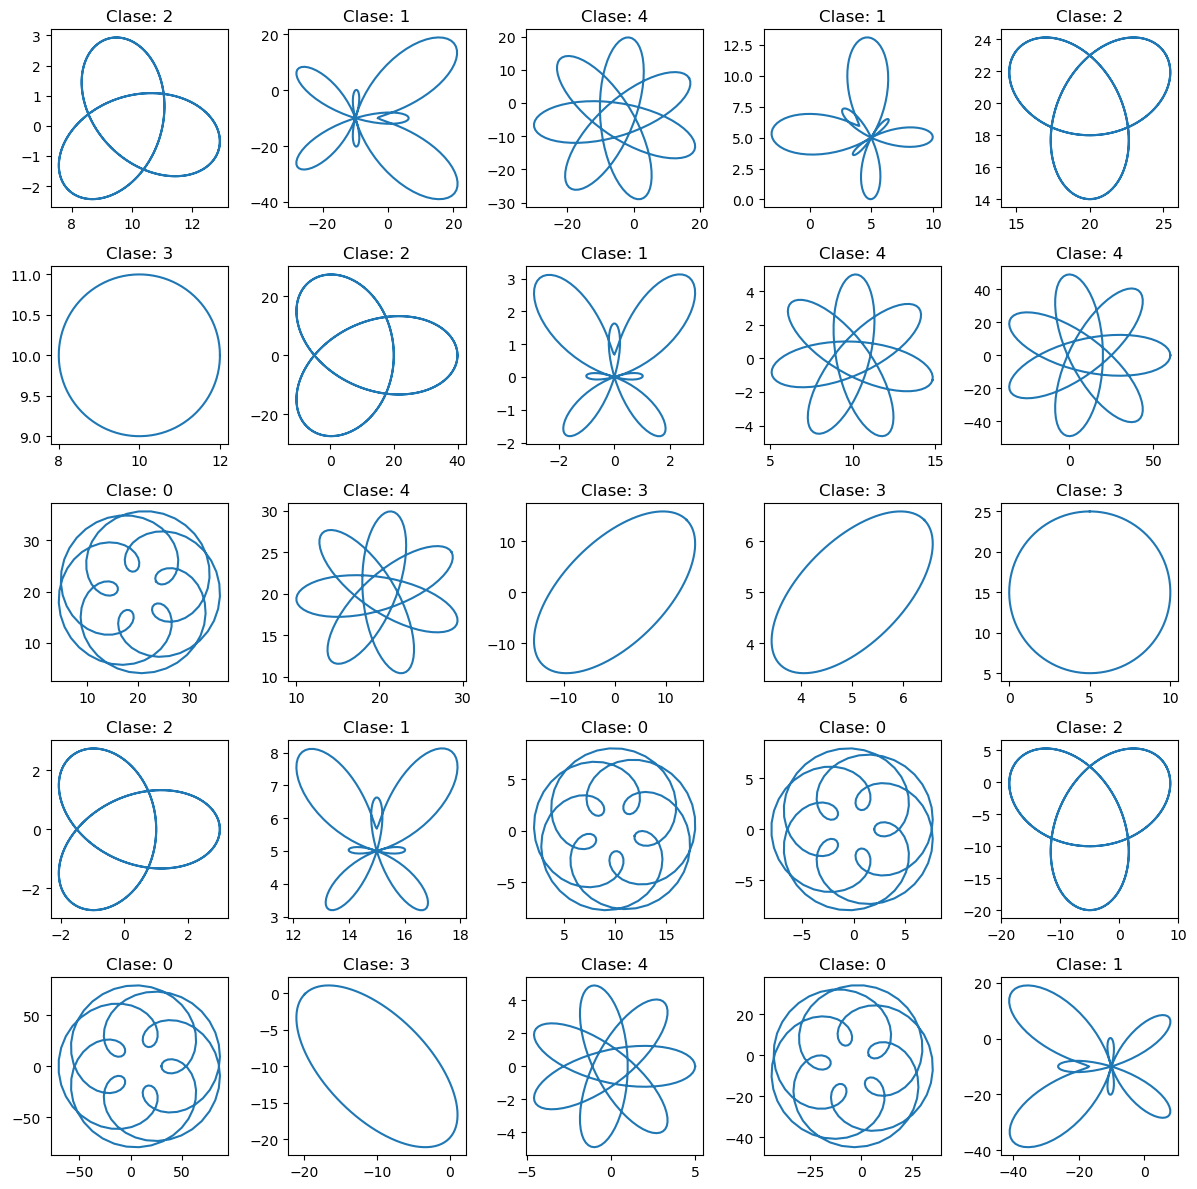

In [244]:
# Crea una figura con 25 subplots
fig, axs = plt.subplots(5, 5, figsize=(12, 12))

# Dibuja cada curva en su subplot correspondiente
for i in range(25):
    row = i // 5
    col = i % 5
    axs[row, col].plot(curvas[i,:,0], curvas[i,:,1])
    axs[row, col].set_title('Clase: {}'.format(labels[i]))

# Ajusta los espacios entre las subplots
fig.tight_layout()

# Muestra la figura
plt.show()

Finalmente vamos a clasificar la nueva curva 

In [245]:
#Cargamos las curvas
new_curva = np.load('new_shape.npy')

In [246]:
new_predictors = fourier_descriptors(new_curva, num_descriptores)

In [247]:
new_label = kmeans.predict([new_predictors])

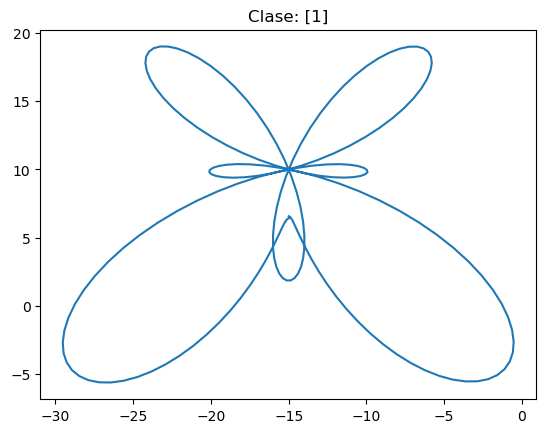

In [248]:
plt.plot(new_curva[:,0],new_curva[:,1])
plt.title("Clase: {}".format(new_label))
plt.show()